In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 


In [32]:
colors_dict = {
    'red': '#d62728',
    'green': '#2ca02c',
    'blue': '#1f77b4',
    'orange': '#ff7f0e',
    'purple': '#9467bd',
    'brown': '#8c564b',
    'pink': '#e377c2',
    'gray': '#7f7f7f',
    'olive': '#bcbd22',
    'cyan': '#17becf',
    'light_blue': '#aec7e8',
    'light_orange': '#ffbb78',
    'light_green': '#98df8a',
    'light_red': '#ff9896',
    'light_purple': '#c5b0d5',
    'light_brown': '#c49c94',
    'light_pink': '#f7b6d2',
    'light_gray': '#c7c7c7',
    'light_olive': '#dbdb8d',
    'light_cyan': '#9edae5'
    }

# Two-armed Bernoulli Bandits

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:  
  Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$   
  Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$   

Upon choosing $\theta$ we get the two states:

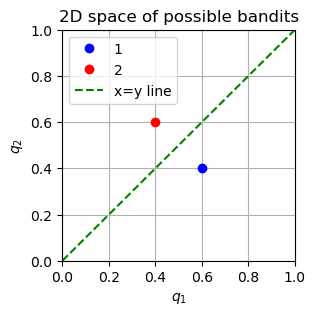

In [33]:
thetatest = 0.6
# Define the coordinates of the two points
point1 = (thetatest, 1- thetatest)
point2 = (1- thetatest, thetatest)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='1')
plt.plot(x2, y2, 'ro', label='2')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# set plot size
plt.gcf().set_size_inches(3, 3)
# Show plot
plt.show()


Following this we define our POMDP parameter values

Since for each $s$: $P(s' | s, a) = 1_{s' = s}$ <br>

We have: $f(y | s', a) = f(y| s, a)$ because irrespective of $a$ we have $s' = s$ <br>
This allows us to use the same QCLP formulation given by the paper


In [189]:
#Define POMDP 

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [190]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [191]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [192]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.2,0.8,0.8,0.2,0.8,0.2,0.2,0.8


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, a, o) \pi(a|q)$ 

And $\sum{q'} P(q', a|q, o) = \pi(a|q)$

In [193]:
def display_df(name= "", vdf = None, adf = None, ndf = None):
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):
        if vdf is not None:
            print("Value " + name)
            print(vdf)
            print("\n")
        if adf is not None:
            print("Action selection "+ name)
            print(adf)
            print("\n")
        if ndf is not None:
            print("Node Transition "+ name)
            print(ndf[ndf["P(q\',a | q,o)"] != 0].T)


Parameters <br>
$\gamma$: discount factor <br>
$b_0(s)$: initial distribution of states <br>
$\rho(q)$: initial distribution over nodes in objective function, either $\rho(q_0) = 1$ or uniform

In [68]:
# discount factor
gamma = 0.9

# b_0(s)
b0 = np.ones((num_states)) / num_states # uniform initial distribution over states

# distribution over nodes
# this fixes the objective function to maximize over y(q_0,s)
obj = "first node" 
# this fixes the objective function to maximize over all y(q,s) with uniform distribution
# obj = "all nodes" 

## Win Stay Lose Shift heuristics
Basic heuristic where in its 2 node FSC version each node corresponds to picking only one action always, staying in that node if observing a win and shifting to the other node when it observes a loss. <br>

$\pi(a_0 | q_0) = 1, P(q_0 | q_0, a_0, o_1) = 1, P(q_0 | q_0, a_0, o_0) = 0$, the pair $(q_1, a_1)$ exhibits symetric behavior

Versions with more nodes try to incorporate more exploration. <br>

We compare the value of these strategies with the result of the QCLP optimization starting from the corresponding x variables (encoding the policy and transition given by the heuristic) and starting from random x points

The values displayed are: <br>

objective funct: $\sum_{s,q}{b_0(s) \rho(q) y(q,s)}$ <br>

mean value: $\sum_{s,q}{\frac{1}{|Q| |S|} y(q,s)}$ <br>

value for nodes $V(q)$: $\sum_{s} {\frac{1}{|S|} y(q,s)} $ <br>

value for states $V(s)$: $\sum_{q} {\frac{1}{|Q|} y(q,s)}$ <br>

where $|Q|$ is the number of nodes and $|S|$ is the number of states

Controller size = 2

In [69]:
# initialize the model variable x with win_stay lose_shift strategy for 2 nodes controller for BB
def win_stay_lose_shift_2_init(newmodel, state_transition_model, observation_model, reward_model, gamma, solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    if qnode == qnodeprime and qnode == actionn and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we stay in {qnodeprime}", newmodel.x[qnodeprime,actionn,qnode,obs].value)
                    elif qnode != qnodeprime and qnode == actionn and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1 
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we shift to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
                    else:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we don't go to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel, state_transition_model, observation_model, reward_model, gamma)
    # Win Stay Lose Shift strategy for two node controller dataframe for BB
    value_WSLS2 = {"(q,s)":[(qi,si) for (qi,si) in product(range(2),range(2))]}
    value_WSLS2["V_WSLS_2(q,s)"] = value_of_strat
    value_WSLS2df = pd.DataFrame(value_WSLS2).T
    value_WSLS2df.columns = value_WSLS2df.iloc[0]
    value_WSLS2df.drop(value_WSLS2df.index[0], inplace=True)
    value_WSLS2df.insert(len(value_WSLS2df.columns),"mean value",float(value_WSLS2df.mean(axis=1)[0]))
    value_WSLS2df.insert(len(value_WSLS2df.columns),"objective funct",(value_WSLS2df[(0,0)]+value_WSLS2df[(0,1)])*0.5)    
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_2_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS2df

In [70]:
num_nodes = 2
newmodel2 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)
newmodel2, vwsls2, adf2, ndf2, value_WSLS2df = win_stay_lose_shift_2_init(newmodel2, state_transition_model, observation_model, reward_model, gamma)
# display_df(vdf = vwsls2, adf = adf2, ndf = ndf2, name = "wsls2")
# use vwsls2 and value_WSLS2df to compare the original strategy with the results of the optimization
vwsls2

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V_WSWS_2_init(q,s)",5.28,5.079999,5.079999,5.28,5.18,5.18,"[5.18, 5.18]","[5.18, 5.18]"


Controller size = 3

In [102]:
# initialize the model variable x with win_stay lose_shift strategy for 3 nodes controller for BB
def win_stay_lose_shift_3_init(newmodel,state_transition_model, observation_model, reward_model, gamma, solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    # if we win in the node corresponding to action, we stay
                    if qnodeprime == qnode and qnode == actionn and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # if we lose in the node corresponding to action, we shift to the intermediate node
                    elif qnodeprime == 2 and qnode == actionn and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # if we win in the intermediate node, we shift to node corresponding to action taken
                    elif qnodeprime == actionn and qnode == 2 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5 * 1 # P(a | 2) = 0.5
                    # if we lose in the intermediate node, we shift to node corresponding to the other action
                    elif qnodeprime!= actionn and qnode == 2 and qnodeprime != 2 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5 * 1 # P(a | 2) = 0.5
                    # the rest is 0
                    else: 
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel, state_transition_model, observation_model, reward_model, gamma)
    # Win Stay Lose Shift strategy for three node controller dataframe for BB
    value_WSLS3 = {"(q,s)":[(qi,si) for (qi,si) in product(range(3),range(2))]}
    value_WSLS3["V_WSLS_3(q,s)"] = value_of_strat
    value_WSLS3df = pd.DataFrame(value_WSLS3).T
    value_WSLS3df.columns = value_WSLS3df.iloc[0]
    value_WSLS3df.drop(value_WSLS3df.index[0], inplace=True)
    value_WSLS3df.insert(len(value_WSLS3df.columns),"mean value",float(value_WSLS3df.mean(axis=1)[0]))
    value_WSLS3df.insert(len(value_WSLS3df.columns),"objective funct",(value_WSLS3df[(0,0)]+value_WSLS3df[(0,1)])*0.5)
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_3_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS3df

In [103]:
num_nodes = 3
newmodel3 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model,obj = obj)
newmodel3, vwsls3, adf3, ndf3, value_WSLS3df = win_stay_lose_shift_3_init(newmodel3, state_transition_model, observation_model, reward_model, gamma)
# display_df(vdf = vwsls3, adf = adf3, ndf = ndf3, name = "wsls3")
# use vwsls3 and value_WSLS3df to compare the original strategy with the results of the optimization
vwsls3

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V_WSWS_3_init(q,s)",5.28,5.08,5.079999,5.280001,5.185156,5.170237,5.18,5.179342,"[5.18, 5.18, 5.178]","[5.182, 5.177]"


Controller size = 4

In [73]:
# initialize the model variable x with win_stay lose_shift strategy for 4 nodes controller for BB
def win_stay_lose_shift_4_init(newmodel,state_transition_model, observation_model, reward_model, gamma, solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    # from node 0 having picked first action and won, we stay
                    if qnode ==  0 and qnodeprime == 0 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 0 having picked first action and lost, we shift to node 1
                    elif qnode == 0 and qnodeprime == 1 and actionn == 0 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 1 having picked first action and won, stochastic transition
                    elif qnode == 1 and qnodeprime == 0 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    elif qnode == 1 and qnodeprime == 2 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    # from node 1 having picked first action and lost again, we shift to node 2
                    elif qnode == 1 and qnodeprime == 2 and actionn == 0 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 2 having picked the second action and won, we stay
                    elif qnode == 2 and qnodeprime == 2 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                     # from node 2 having picked the second action and lost, we shift to node 3
                    elif qnode == 2 and qnodeprime == 3 and actionn == 1 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 3 having picked the second action and won, stochastic transition
                    elif qnode == 3 and qnodeprime == 2 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    elif qnode == 3 and qnodeprime == 0 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    # from node 3 having picked the second action and lost again, we shift to node 0
                    elif qnode == 3 and qnodeprime == 0 and actionn == 1 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # else = 0
                    else:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel,state_transition_model, observation_model, reward_model, gamma)
    # Win Stay Lose Shift strategy for four node controller dataframe for BB
    value_WSLS4 = {"(q,s)":[(qi,si) for (qi,si) in product(range(4),range(2))]}
    value_WSLS4["V_WSLS_4(q,s)"] =  value_of_strat
    value_WSLS4df = pd.DataFrame(value_WSLS4).T
    value_WSLS4df.columns = value_WSLS4df.iloc[0]
    value_WSLS4df.drop(value_WSLS4df.index[0], inplace=True)
    value_WSLS4df.insert(len(value_WSLS4df.columns),"mean value",float(value_WSLS4df.mean(axis=1)[0]))
    value_WSLS4df.insert(len(value_WSLS4df.columns),"objective funct",(value_WSLS4df[(0,0)]+value_WSLS4df[(0,1)])*0.5)
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_4_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS4df   

In [74]:
num_nodes = 4
newmodel4 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
newmodel4, vwsls4, adf4, ndf4, value_WSLS4df = win_stay_lose_shift_4_init(newmodel4,state_transition_model, observation_model, reward_model, gamma)
# display_df(vdf = vwsls4, adf = adf4, ndf = ndf4, name = "wsls4")
# use vwsls4 and value_WSLS4df to compare the original strategy with the results of the optimization
vwsls4

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V_WSWS_4_init(q,s)",5.227832,5.227832,5.138474,5.223365,4.928773,5.544857,4.738177,5.671921,5.227832,5.214341,"[5.228, 5.181, 5.237, 5.205]","[5.008, 5.417]"


Graph visualization

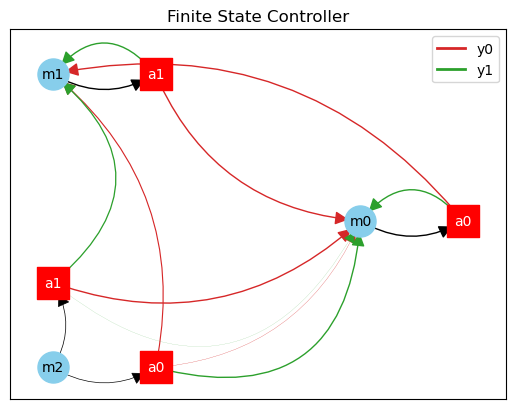

In [75]:
# colors for each observation
obs_color = {"red": colors_dict["red"], "green": colors_dict["green"]}
# choose which model to display
model_to_display = newmodel3
fsc_graph(model_to_display,obs_color)

Occupancy of node and state pair $\eta$ where: <br>
$\eta = (I - T)^{-1} \rho$ <br>

or for all (s',q'):<br>
$\eta(s',q') = \sum_{(s,q)}{T(s',q' | s, q) \eta(s,q) + \rho(s',q')}$ <br>

where: <br>
$T(s',q' | s, q) = \sum_{a,y}{\pi(a | q) P(s' | s, a) O(o | s', a) P(q' | q, a, o)}$

In [76]:
# choose model to calculate eta
modeltocalc = newmodel3
# calculate eta
eta = eta_calculation(modeltocalc, state_transition_model, observation_model, gamma)
# display df
etadf = pd.DataFrame({"(s,q)": list(eta.keys()), "eta(s,q)": list(eta.values())}).T
etadf.columns = etadf.iloc[0]
etadf.drop(etadf.index[0], inplace=True)
etadf

"(s,q)","(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)"
"eta(s,q)",2.873919,1.958856,0.167225,1.97768,2.854932,0.167387


## Generating instances 
where the x variables are restarted randomly to cover more of the search space

In [91]:
number_instances = 5
controller_size_list = [2,3,4]
ssol = opt_instances(controller_size_list, number_instances,num_states, num_actions, num_observations, b0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
ssol["dataframe"]

,max obj,mean obj,mean value,mean value for nodes V(q),mean value for states V(s)
controller size,,,,,
2,5.180000,5.180000,5.180,"[5.18, 5.18]","[5.18, 5.18]"
3,5.227832,5.198660,5.195,"[5.2, 5.204, 5.184]","[5.25, 5.138]"
4,5.305529,5.305529,5.270,"[5.31, 5.226, 5.264, 5.28]","[5.256, 5.284]"


In [92]:
# Value of controllers given a controller size
# controllersize = 4
# sol[controllersize]["value df"]

# Action selection given a controller size
# sol[controllersize]["action select df"]

# Node transitions given a controller size
# with pd.option_context('display.max_rows', None,'display.max_columns', None,'display.precision', 3):
# sol[controllersize]["node trans df"]

## Comparison of results
We compare the objective function of random RESTART where x is given random values, WSLS RESTART where it's given the value of the WSWS strategy and the WSLS heuristic itself for the given controller sizes

In [93]:
comparisondf = pd.DataFrame({"controller size":[2,3,4],
                             "random RESTART": list(ssol["dataframe"]["max obj"]),
                             "WSLS RESTART": [vwsls2["objective funct"][0],vwsls3["objective funct"][0], vwsls4["objective funct"][0]],
                             "WSLS": [value_WSLS2df["objective funct"][0],value_WSLS3df["objective funct"][0],value_WSLS4df["objective funct"][0]]})
comparisondf.set_index("controller size", inplace=True)
comparisondf

,random RESTART,WSLS RESTART,WSLS
controller size,,,
2,5.180000,5.180000,5.180000
3,5.227832,5.180000,5.212264
4,5.305529,5.227832,5.165057


## Bayesian POMDP solution
Now we compare the value of a belief $V(b)$ with the objective function of the optimization where $b_0 = b$

$V(b)$ is given by the bellman equation:  <br>

$V(b) = \max_{a}{\sum_{s', s, o}{b(s) \pi(a | b) P(s' | s, a) O(o | s', a) (r(s', a, s) + \gamma V(T(b,a,o)))}}$ <br>

where the belief update $T(b,a,o) = b'$ is given by: <br>

$b'(s') = \frac{\sum_{s} b(s) P(s' | s, a) O(o | s', a)}{\sum_{s',s} b(s) P(s' | s, a) O(o | s', a)}$ <br>

We do this by creating a subset of belief points $B= (b_1, b_2, ...b_N)$ and we calculate each $V(b_i)$ by performing value iteration where each belief update will be projected back to one of the belief points $T(b_i, a, o) \in B$<br>

All belief points $b_i$ can be represented as a point on the segment $[0,1]$ since we have two state that point in the segment will represent $b_i(s)$ <br>in this case $s = s_1$

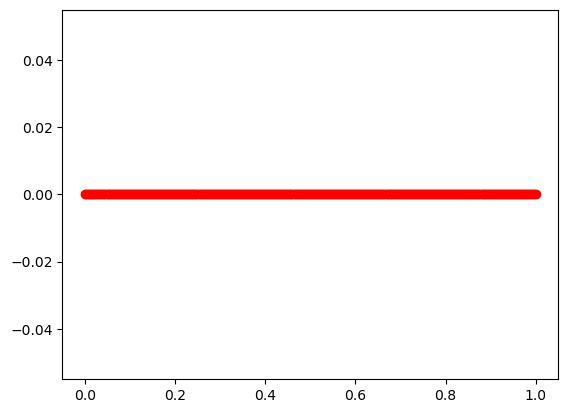

In [130]:
# construct belief points on segment
def belief_points(num_points):
    # define segment
    segment = (0,1)
    # return list of belief points where first element if belief to be in the first state
    # and second element is belief to be in the second state
    return [(point, 1 - point) for point in list(np.linspace(segment[0],segment[1],num_points))]
b = belief_points(300)
# plot first element in points in b on segment
plt.plot([point[0] for point in b], [0 for point in b], 'ro')

In [131]:
# belief update function
def belief_update(belief_point, action, observation, state_transition_model, observation_model):
    # belief update formula
    new_belief_point = [0 for i in range(len(belief_point))]
    for sprime in range(len(belief_point)):
        # sum_s b(s) * P(s'|s,a) * O(o|s', a)
        numerator = sum(belief_point[state] *
                        observation_model[sprime, action, observation] *
                        state_transition_model[sprime, action, state] 
                        for state in range(len(belief_point)))
        # sum_s,s' b(s) * P(s'|s,a) * O(o|s', a)
        denominator = sum(belief_point[state] *
                        observation_model[sp, action, observation] *
                        state_transition_model[sp, action, state] 
                        for state,sp in product(range(len(belief_point)),range(len(belief_point)))
                        )
        if denominator != 0:
            new_belief_point[sprime] = numerator / denominator
    return tuple(new_belief_point)
# new_belief_point = belief_update(b[0], 1, 0, state_transition_model, observation_model)
# type(new_belief_point)

In [132]:
# closest belief function
def closest_belief(belief_point, belief_list):
    return min(belief_list, key = lambda x: sum((x[i] - belief_point[i])**2 for i in range(len(belief_point))))
# type(closest_belief((0.6,0.4),[(0,1),(1,0)]))

In [133]:
# value iteration algorithm
def value_iteration_bp(beliefpoints, tol, state_transition_model, observation_model, rewards, num_states, num_actions, num_observations, gamma):
    # initialize value function V(b) = 0 for each b
    valuefun = { bp: 0 for bp in beliefpoints}
    tempvaluefun = { bp: 0 for bp in beliefpoints}
    # best action
    bestaction = {bp: 0 for bp in beliefpoints}
    # value iteration algo
    # i = 0
    while True:
        # delta which tells us to stop after exceeding tolerance
        delta = 0
        #print(i)
        for bp in beliefpoints:
            # bellman operator
            quality = [0 for i in range(num_actions)]
            for action in range(num_actions):
                # sum_s,s',y b(s) * P(s'| s, a) * f(y| s', a) * (r(s,a) + gamma * V(b'(.|a, y)))
                quality[action] = sum(
                bp[state]* 
                observation_model[stateprime, action, obs]* 
                state_transition_model[stateprime, action, state]*
                (rewards[state,action]+
                gamma *
                valuefun[closest_belief(
                belief_update(bp, action, obs, state_transition_model, observation_model),
                beliefpoints
                )]
                ) 
                for state, stateprime, obs in 
                product(range(num_states), range(num_states), range(num_observations)))
            # take max over actions and update V'
            tempvaluefun[bp] = max(quality)
            # update best action
            bestaction[bp] = quality.index(max(quality))
            # update delta = max(delta, |V(b) - V'(b)|)
            delta = max(delta, abs(tempvaluefun[bp] - valuefun[bp]))
        # update value function V <- V'
        valuefun = tempvaluefun.copy()
        # print(delta)
        if delta <= tol:
            break
        # i += 1
    return valuefun, bestaction

In [194]:
v,ba = value_iteration_bp(b,10**-8, 
                        state_transition_model, observation_model, reward_model, 
                        num_states, num_actions, num_observations, 
                        gamma)

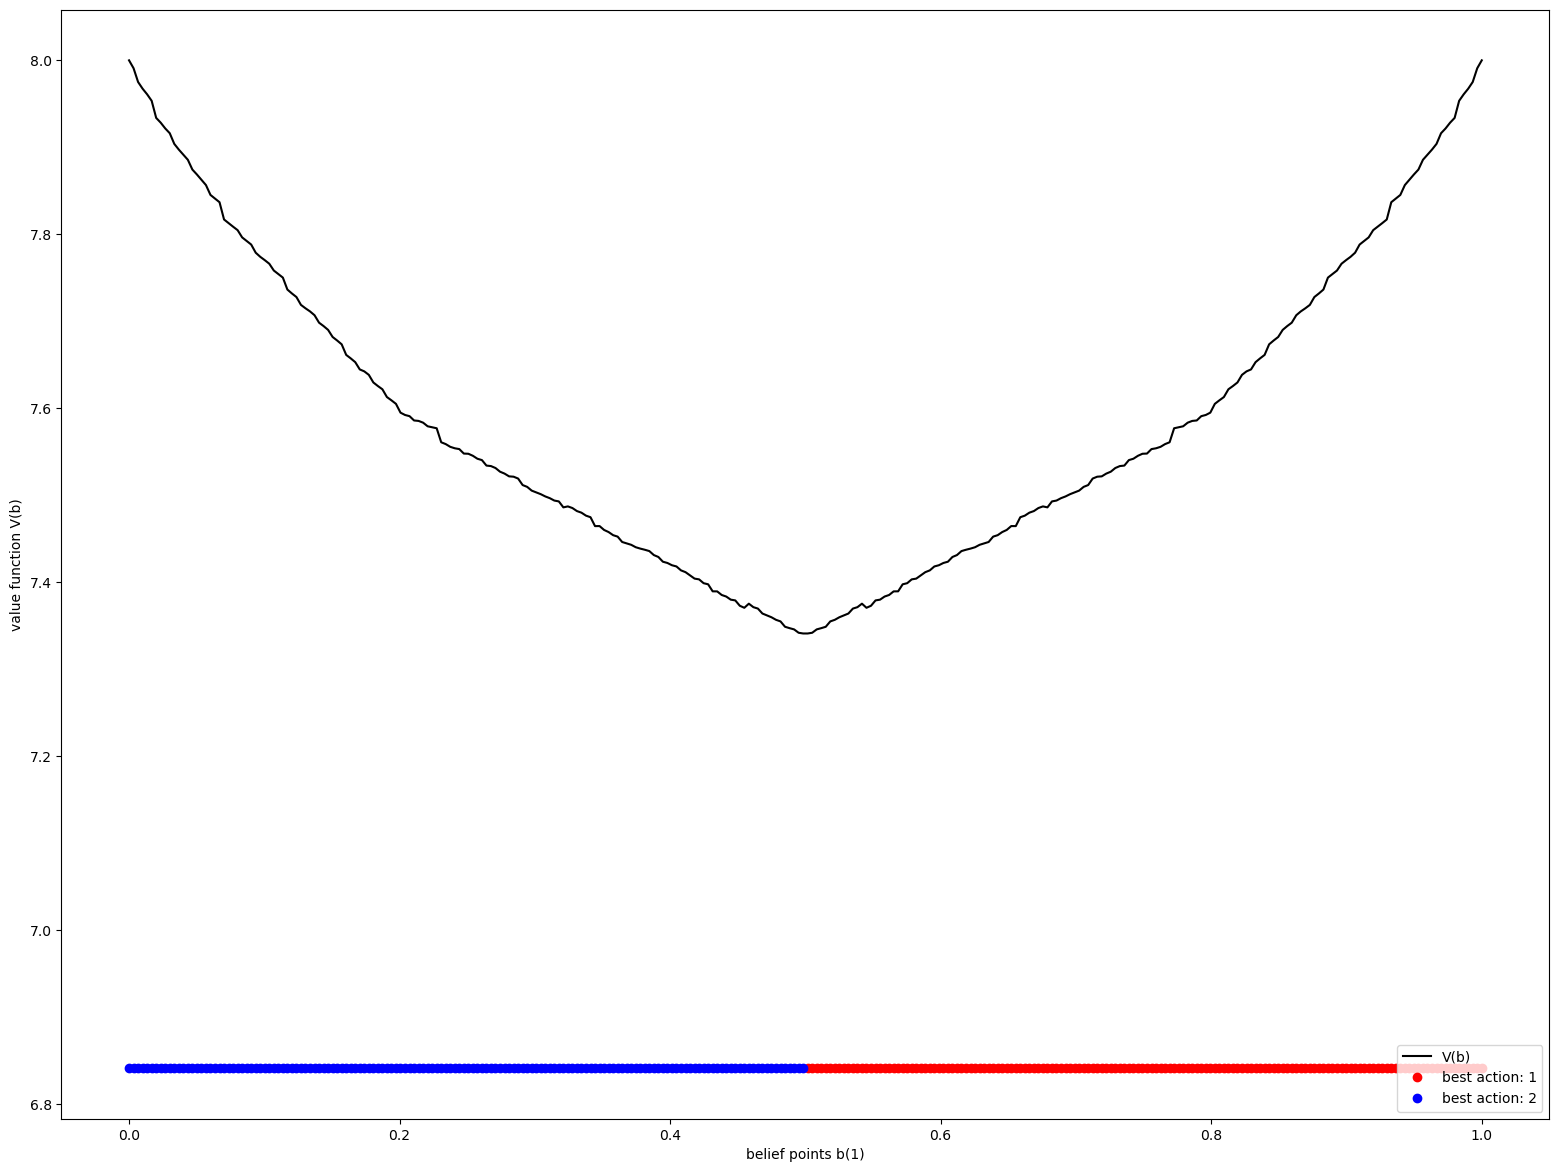

In [195]:
plt.figure(figsize=(6.4*3, 4.8*3))
# plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")
# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")
# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")
# legend
plt.xlabel("belief points b(1)")
plt.ylabel("value function V(b)")
plt.legend(loc = "lower right")
plt.show()

## Comparison with FSC
for each $b_i \in B$ we compare $V(b_i)$ with the objective function where the initial distribution over states $b_0 = b_i$


In [196]:
# compare with FSC QCLP
number_instances = 3
controller_size_list = [2, 3, 4]
# dictionary containing for each FSC size the objective function
valuefsc = {fsc_size: [] for fsc_size in controller_size_list}
# choosing a random sample of belief points for less optimization calls
sample_size = 10
# evenly spaced belief points on segment
sample_b = belief_points(sample_size)
# in case the belief points generated are not in the other list of belief points
sample_b = [ closest_belief(bp,b) for bp in sample_b]
# sort the sample for clean plotting
# sample_b.sort(key= lambda x: x[0])
for fsc_size in controller_size_list:
    for bp in sample_b:
        # b0 distribution over states according to belief point
        bdist = np.array(bp)
        # run QCLP optimization
        sol = opt_instances([fsc_size],
                            number_instances,num_states, num_actions, num_observations, 
                            bdist, gamma, 
                            state_transition_model, reward_model, observation_model, 
                            obj = obj)
        # add max objective funciton under this belief point 
        valuefsc[fsc_size].append(sol[fsc_size]["max obj"])

In [197]:
df = pd.DataFrame(valuefsc).T
df

,0,1,2,3,4,5,6,7,8,9
2,8.0,7.358835,6.970156,6.751447,6.653110,6.65311,6.751448,6.970156,7.337793,8.000002
3,8.0,7.563286,7.291932,7.161799,7.040460,7.04046,7.074414,7.332808,7.563286,8.000000
4,8.0,7.668061,7.469307,7.074414,7.071124,7.17285,7.254493,7.406166,7.638788,8.000000


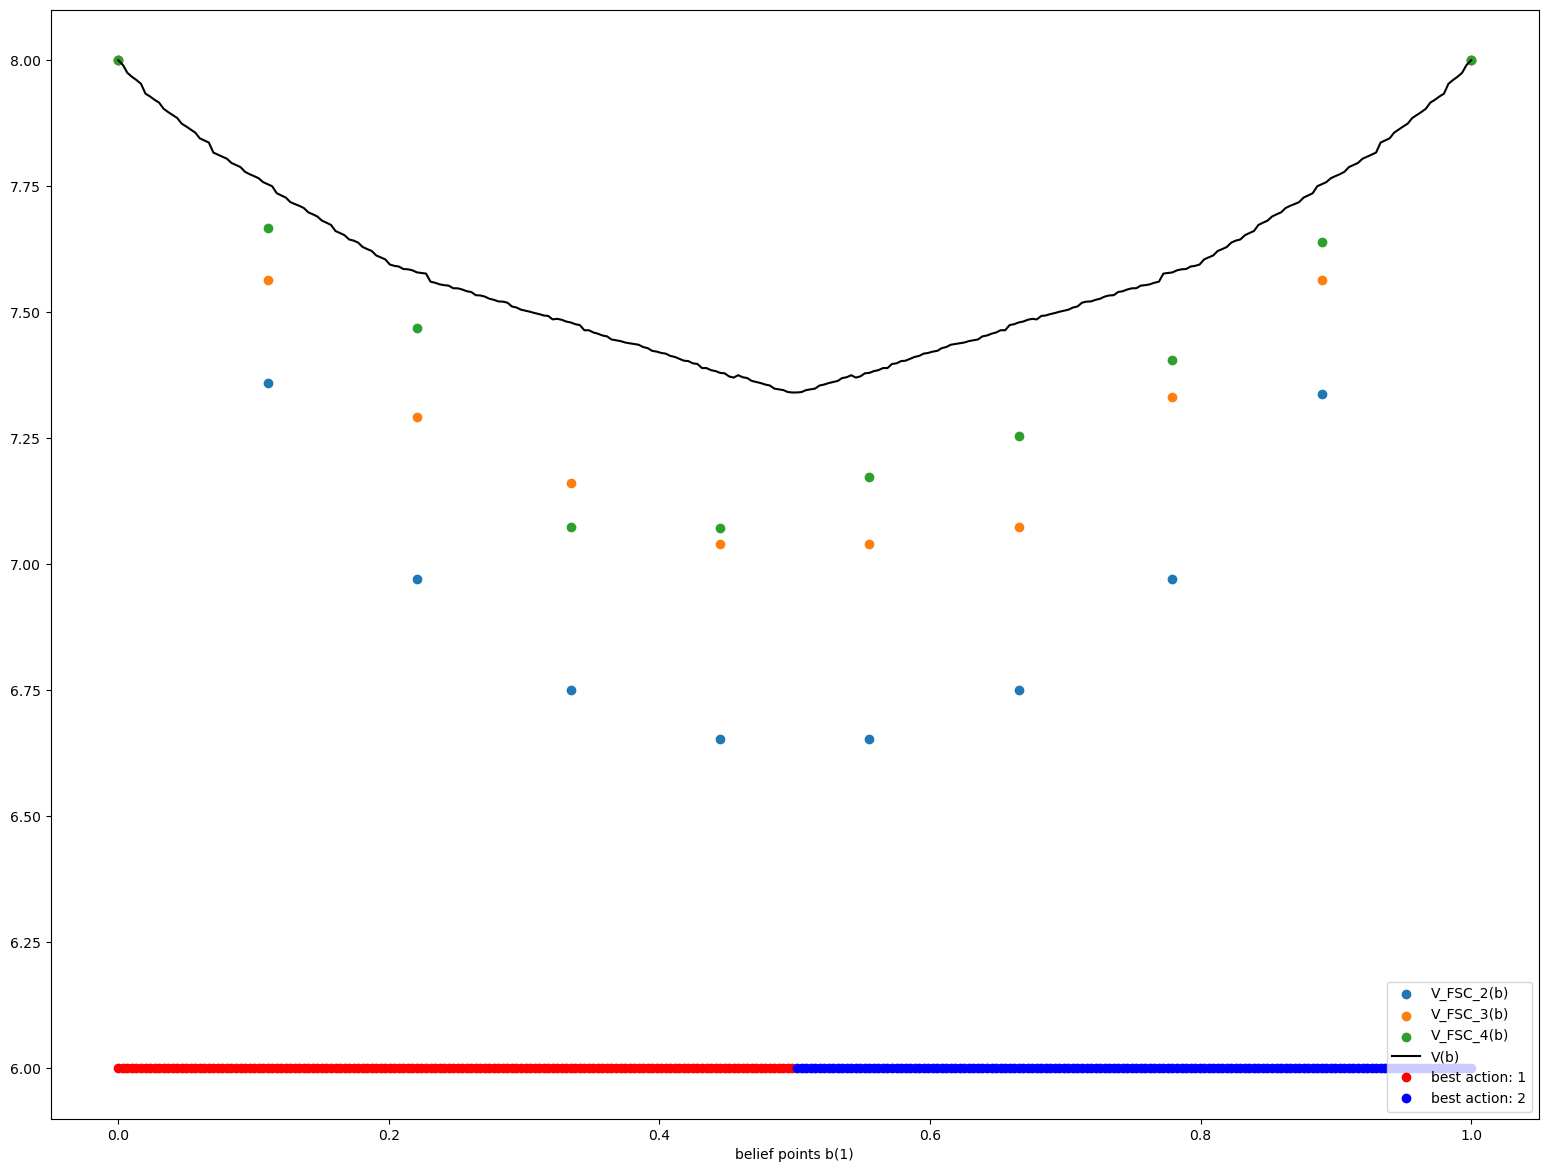

In [204]:
plt.figure(figsize=(6.4*3, 4.8*3))
# plot objective function for each size
for fsc_size in controller_size_list:
    plt.scatter([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [6 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [6 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.xlabel("belief points b(1)")
plt.legend(loc = "lower right")
plt.show()

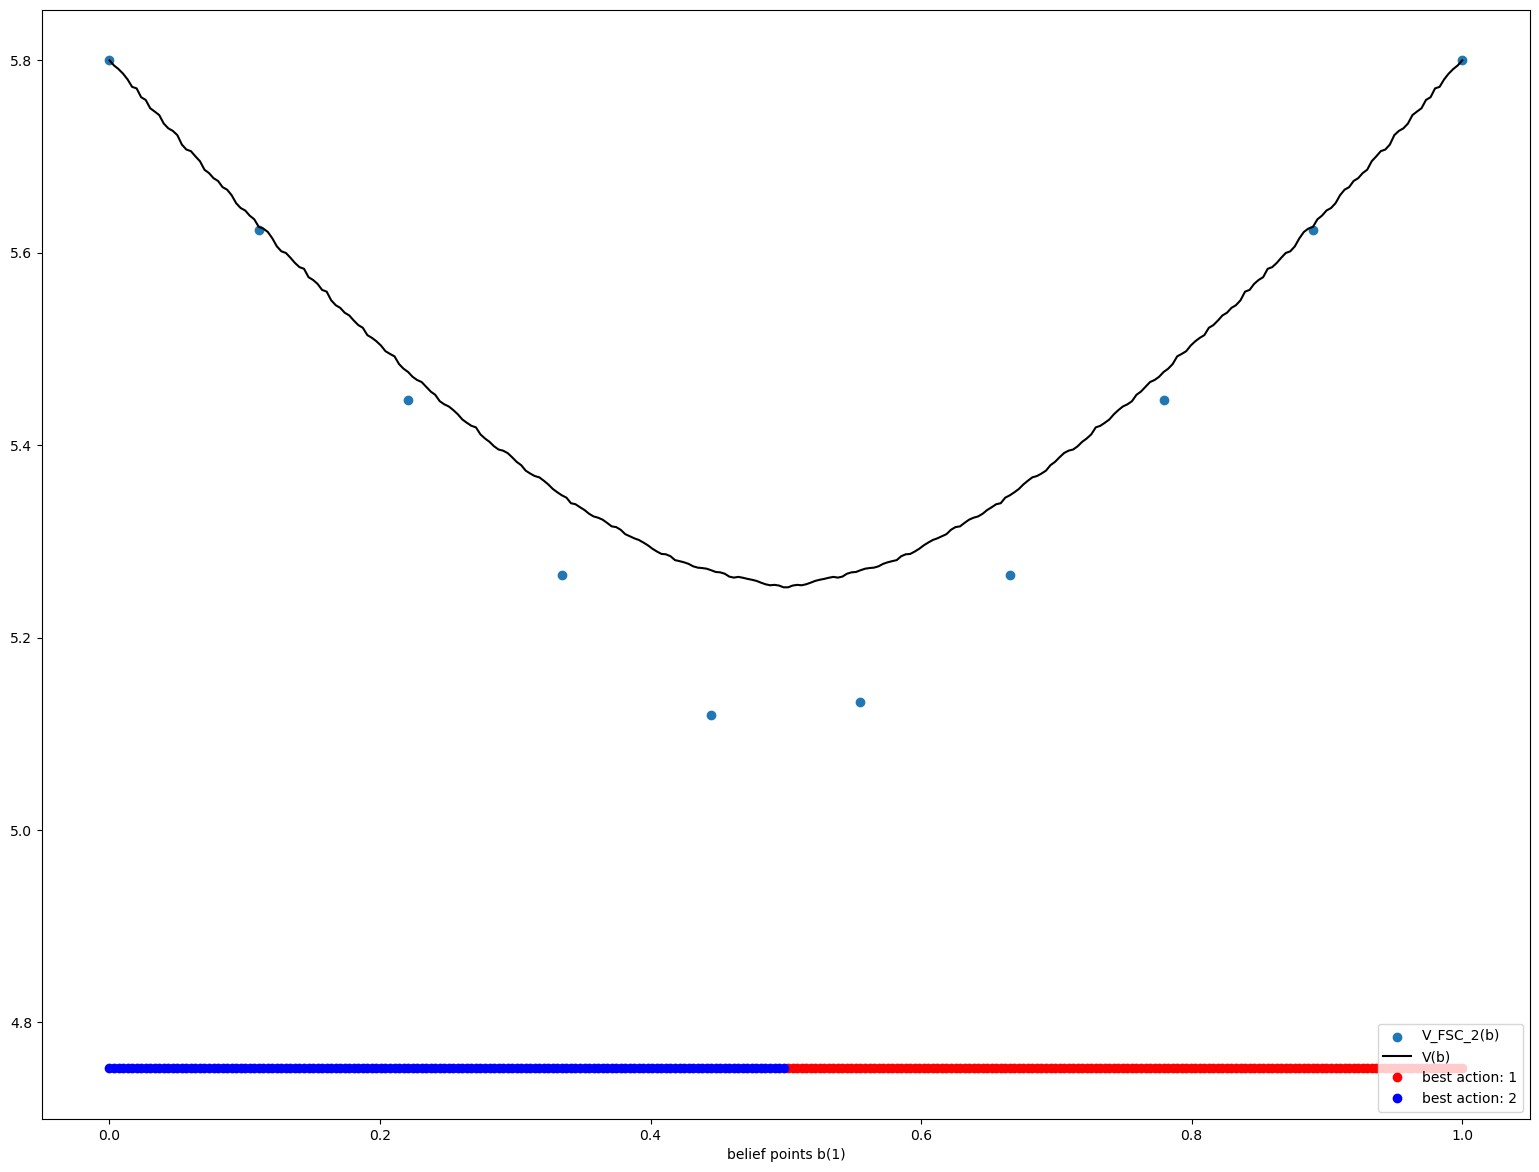

In [185]:
plt.figure(figsize=(6.4*3, 4.8*3))
fsc_size = 2
plt.scatter([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.xlabel("belief points b(1)")
plt.legend(loc = "lower right")
plt.show()

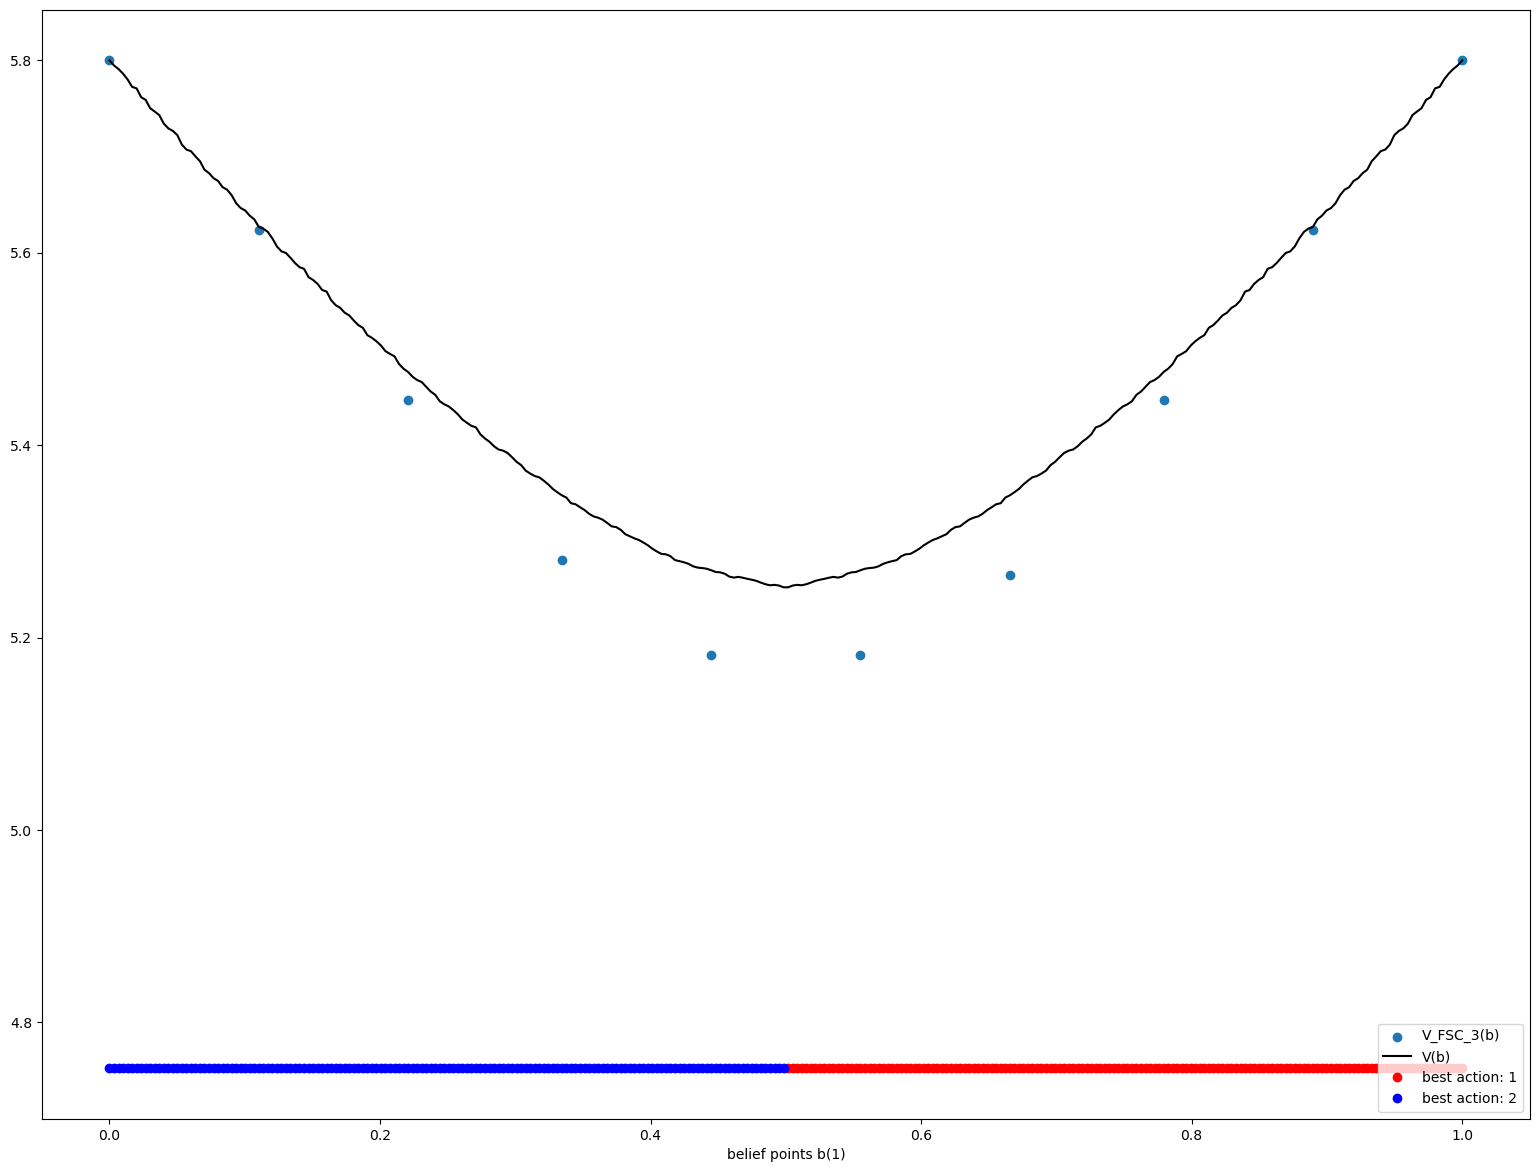

In [186]:
plt.figure(figsize=(6.4*3, 4.8*3))

fsc_size = 3
plt.scatter([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.xlabel("belief points b(1)")
plt.legend(loc = "lower right")
plt.show()

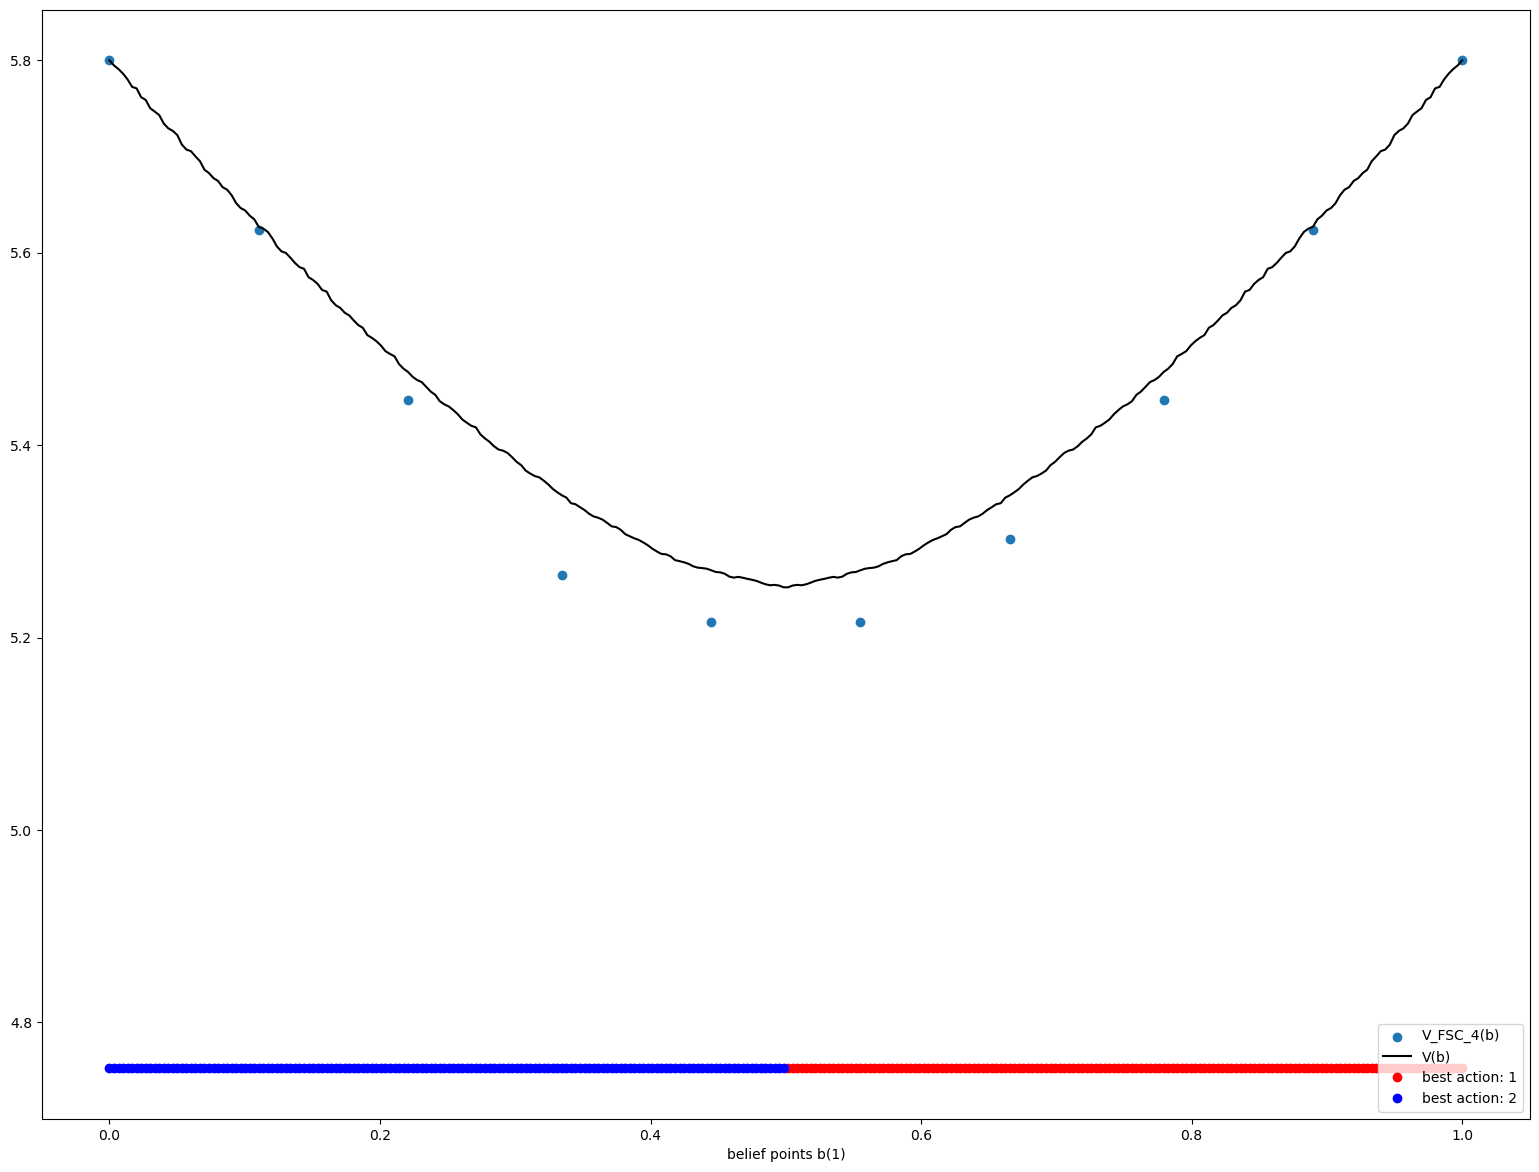

In [187]:
plt.figure(figsize=(6.4*3, 4.8*3))
fsc_size = 4
plt.scatter([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.xlabel("belief points b(1)")
plt.legend(loc = "lower right")